# Get first conv weights of a network trained on imagenet

In [1]:
import tensorflow as tf
import larq as lq

import os
import sys

import tensorflow as tf
import larq as lq

In [2]:
binarycenternet_path = os.path.join('..')

# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, binarycenternet_path)

In [3]:
# import custom modules
from utils.processing_tools import *
from utils.generators import *
from utils.model_tools import *
from utils.video_utils import *
from architectures import *

import pyximport
pyximport.install(reload_support=True)
from utils.evaluate import *

from utils.loss import *
from utils.model_tools import *
from utils.architecture import *

In [4]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.preprocessing.image
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
from datetime import date, timedelta
import time
from six import raise_from

# import custom modules
from utils.processing_tools import *
from utils.generators import *
from utils.augmentor.misc import MiscEffect
from utils.augmentor.color import VisualEffect

# remove the try in final version

import pyximport
pyximport.install(reload_support=True)
from utils.evaluate import *

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

# Set model params

In [7]:
import larq as lq

from tensorflow.keras.layers import Input, Conv2DTranspose, DepthwiseConv2D, Activation, Add, UpSampling2D, ZeroPadding2D, BatchNormalization, ReLU, Conv2D, Lambda, MaxPooling2D, Dropout
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_normal, constant, zeros
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import numpy as np
import larq_zoo as lqz
from urllib.request import urlopen
from larq.layers import QuantConv2D as QuantConv2D
from tensorflow import Tensor

In [8]:
input_size=(512,512)
num_classes = 20
max_objects=100
score_threshold=0.1
nms=True

output_size = input_size[0] // 4
image_input = Input(shape=(input_size[0], input_size[1], 3))
hm_input = Input(shape=(output_size, output_size, num_classes))
wh_input = Input(shape=(max_objects, 2))
reg_input = Input(shape=(max_objects, 2))
reg_mask_input = Input(shape=(max_objects,))
index_input = Input(shape=(max_objects,))

# Download resnet50 model

In [9]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=image_input,
    input_shape=None,
    pooling=None,
)

In [10]:
lq.models.summary(resnet50)

+resnet50 stats--------------------------------------------------------------------------+
| Layer                Input prec.              Outputs  # 32-bit    Memory  32-bit MACs |
|                            (bit)                            x 1      (kB)              |
+----------------------------------------------------------------------------------------+
| input_1                        -    (-1, 512, 512, 3)         0         0            ? |
| conv1_pad                      -    (-1, 518, 518, 3)         0         0            ? |
| conv1_conv                     -   (-1, 256, 256, 64)      9472     37.00    616562688 |
| conv1_bn                       -   (-1, 256, 256, 64)       128      0.50            0 |
| conv1_relu                     -   (-1, 256, 256, 64)         0         0            ? |
| pool1_pad                      -   (-1, 258, 258, 64)         0         0            ? |
| pool1_pool                     -   (-1, 128, 128, 64)         0         0            0 |

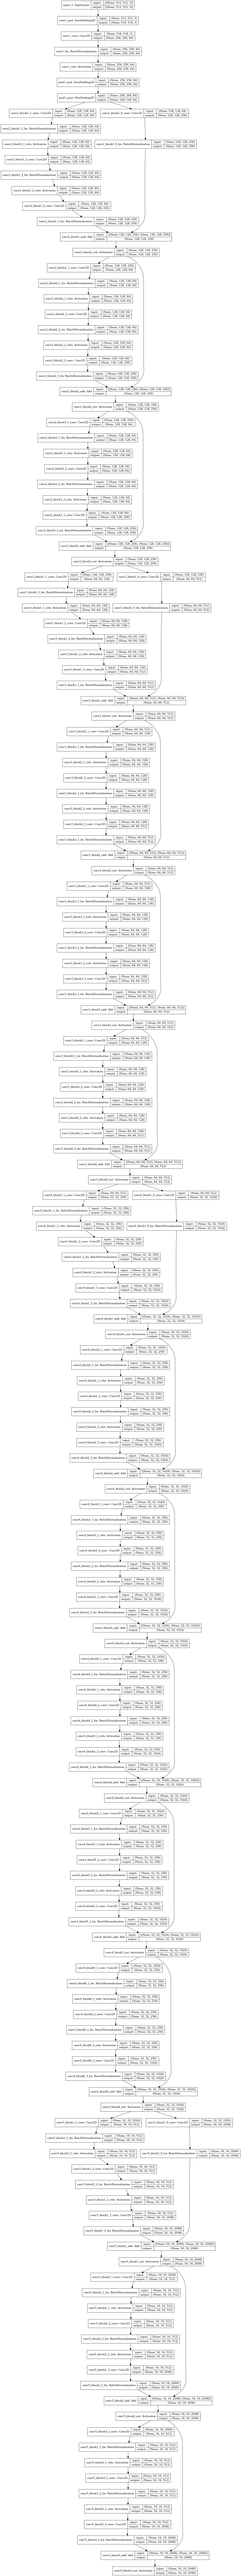

In [11]:
# save to png at currect dir
tf.keras.utils.plot_model(resnet50, to_file='model.png', show_shapes=True)

# Get model weights

In [12]:
i = 0
for i, layer in enumerate(resnet50.layers): 
    #print(layer.get_config(), layer.get_weights())
    print("Operation index = {}".format(i))
    print(layer.get_config())
    print('\n')

Operation index = 0
{'batch_input_shape': (None, 512, 512, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}


Operation index = 1
{'name': 'conv1_pad', 'trainable': True, 'dtype': 'float32', 'padding': ((3, 3), (3, 3)), 'data_format': 'channels_last'}


Operation index = 2
{'name': 'conv1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (7, 7), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


Operation index = 3
{'name': 'conv1_bn', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale'

# Create a CenterNet

In [13]:
def centernet(num_classes, input_size=(512,512), max_objects=100, score_threshold=0.1,
              nms=True,
              flip_test=False,
              freeze_bn=True):
    
    output_size = input_size[0] // 4
    image_input = Input(shape=(input_size[0], input_size[1], 3))
    hm_input = Input(shape=(output_size, output_size, num_classes))
    wh_input = Input(shape=(max_objects, 2))
    reg_input = Input(shape=(max_objects, 2))
    reg_mask_input = Input(shape=(max_objects,))
    index_input = Input(shape=(max_objects,))

    # create resnet

    resnet = tf.keras.applications.resnet50.ResNet50(input_tensor = image_input, include_top=False, weights=None)

    # (b, 16, 16, 2048)
    C5 = resnet.outputs[-1]
    # C5 = resnet.get_layer('activation_49').output
    x = Dropout(rate=0.5)(C5)
    # decoder
    num_filters = 256
    for i in range(3):
        num_filters = num_filters // pow(2, i)
        # x = Conv2D(num_filters, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(
        #     x)
        # x = BatchNormalization()(x)
        # x = ReLU()(x)
        x = Conv2DTranspose(num_filters, (4, 4), strides=2, use_bias=False, padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(5e-4))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    # hm header
    y1 = Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(x)
    y1 = BatchNormalization()(y1)
    y1 = ReLU()(y1)
    y1 = Conv2D(num_classes, 1, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4), activation='sigmoid')(y1)

    # wh header
    y2 = Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(x)
    y2 = BatchNormalization()(y2)
    y2 = ReLU()(y2)
    y2 = Conv2D(2, 1, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(y2)

    # reg header
    y3 = Conv2D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(x)
    y3 = BatchNormalization()(y3)
    y3 = ReLU()(y3)
    y3 = Conv2D(2, 1, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(y3)

    loss_ = Lambda(loss, name='centernet_loss')(
        [y1, y2, y3, hm_input, wh_input, reg_input, reg_mask_input, index_input])
    model = Model(inputs=[image_input, hm_input, wh_input, reg_input, reg_mask_input, index_input], outputs=[loss_])

    # detections = decode(y1, y2, y3)
    detections = Lambda(lambda x: decode(*x,
                                         max_objects=max_objects,
                                         score_threshold=score_threshold,
                                         nms=nms,
                                         flip_test=flip_test,
                                         num_classes=num_classes))([y1, y2, y3])
    prediction_model = Model(inputs=image_input, outputs=detections)
    debug_model = Model(inputs=image_input, outputs=[y1, y2, y3])
    return model, prediction_model, debug_model

In [14]:
# create model given an architecture
# (the centernet input must be specified by the architecture file)
centernet_train, centernet_predict, centernet_hmaps = centernet(input_size = input_size, num_classes = num_classes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
lq.models.summary(centernet_train)

+model stats--------------------------------------------------------------------------------+
| Layer                  Input prec.              Outputs  # 32-bit     Memory  32-bit MACs |
|                              (bit)                            x 1       (kB)              |
+-------------------------------------------------------------------------------------------+
| input_7                          -    (-1, 512, 512, 3)         0          0            ? |
| conv1_pad                        -    (-1, 518, 518, 3)         0          0            ? |
| conv1_conv                       -   (-1, 256, 256, 64)      9472      37.00    616562688 |
| conv1_bn                         -   (-1, 256, 256, 64)       128       0.50            0 |
| conv1_relu                       -   (-1, 256, 256, 64)         0          0            ? |
| pool1_pad                        -   (-1, 258, 258, 64)         0          0            ? |
| pool1_pool                       -   (-1, 128, 128, 64)   

# Custom stem module with Resnet50 weights

In [16]:
# check architecture repo: 
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py 
def resnet50_conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = tf.keras.layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = tf.keras.layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = tf.keras.layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = tf.keras.layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = tf.keras.layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = tf.keras.layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [17]:
# check architecture repo: 
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py 
def stem_module_resnet50(x, filters = 256):
    """Start of network."""
    
    assert filters == 256 # must be equal to resnet50
    
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = tf.keras.layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = resnet50_conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    return x


## Create stem

In [18]:
x = stem_module_resnet50(image_input)
stem_module = Model(inputs=[image_input], outputs=[x])
lq.models.summary(stem_module)

+model_3 stats--------------------------------------------------------------------+
| Layer           Input prec.              Outputs  # 32-bit  Memory  32-bit MACs |
|                       (bit)                            x 1    (kB)              |
+---------------------------------------------------------------------------------+
| input_1                   -    (-1, 512, 512, 3)         0       0            ? |
| conv1_pad                 -    (-1, 518, 518, 3)         0       0            ? |
| conv1                     -   (-1, 256, 256, 64)      9472   37.00    616562688 |
| bn_conv1                  -   (-1, 256, 256, 64)       128    0.50            0 |
| activation                -   (-1, 256, 256, 64)         0       0            ? |
| pool1_pad                 -   (-1, 258, 258, 64)         0       0            ? |
| max_pooling2d             -   (-1, 128, 128, 64)         0       0            0 |
| res2a_branch2a            -   (-1, 128, 128, 64)      4160   16.25     671

## Copy resnet50 weights to stem

In [19]:
count = 0
for layer_id, layer in enumerate(stem_module.layers): 
    count += 1
    #print(layer.get_config(), layer.get_weights())
    print('Copying layer weights from resnet50 to stem index = {}'.format(i))
    w_copy = resnet50.layers[layer_id].get_weights()
    stem_module.layers[layer_id].set_weights(w_copy)
    try:
        if tf.math.equal(stem_module.layers[layer_id].get_weights(), resnet50.layers[layer_id].get_weights()):
            print('Success...')
    except:
        print('Something happened. Check.')
print('there are {} layers on the stem of resnet50'.format(count))

Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from resnet50 to stem index = 174
Copying layer weights from resnet50 to stem index = 174
Something happened. Check.
Copying layer weights from 

In [20]:
lq.models.summary(stem_module)

+model_3 stats--------------------------------------------------------------------+
| Layer           Input prec.              Outputs  # 32-bit  Memory  32-bit MACs |
|                       (bit)                            x 1    (kB)              |
+---------------------------------------------------------------------------------+
| input_1                   -    (-1, 512, 512, 3)         0       0            ? |
| conv1_pad                 -    (-1, 518, 518, 3)         0       0            ? |
| conv1                     -   (-1, 256, 256, 64)      9472   37.00    616562688 |
| bn_conv1                  -   (-1, 256, 256, 64)       128    0.50            0 |
| activation                -   (-1, 256, 256, 64)         0       0            ? |
| pool1_pad                 -   (-1, 258, 258, 64)         0       0            ? |
| max_pooling2d             -   (-1, 128, 128, 64)         0       0            0 |
| res2a_branch2a            -   (-1, 128, 128, 64)      4160   16.25     671

# Same procedure for quicknet input

In [37]:
# All quantized layers will use the same binary options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

@lq.utils.register_keras_custom_object
def blurpool_initializer(shape, dtype=None):
    """Initializer for anti-aliased pooling.
    # References
        - [Making Convolutional Networks Shift-Invariant Again](https://arxiv.org/abs/1904.11486)
    """
    ksize, filters = shape[0], shape[2]

    if ksize == 2:
        k = np.array([1, 1])
    elif ksize == 3:
        k = np.array([1, 2, 1])
    elif ksize == 5:
        k = np.array([1, 4, 6, 4, 1])
    else:
        raise ValueError("filter size should be in 2, 3, 5")

    k = np.outer(k, k)
    k = k / np.sum(k)
    k = np.expand_dims(k, axis=-1)
    k = np.repeat(k, filters, axis=-1)
    return np.reshape(k, shape)

# check architecture repo: 
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py 
def stem_module_resnet50(x, filters = 256):
    """Start of network."""
    
    assert filters == 256 # must be equal to resnet50
    
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = tf.keras.layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = resnet50_conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    return x


def residual_block(x):
    """Standard residual block, without strides or filter changes."""

    residual = x

    x = lq.layers.QuantConv2D(
        int(x.shape[-1]),
        (3, 3),
        activation="relu",
        **kwargs,
        kernel_initializer="glorot_normal",
        padding="same",
        pad_values=1.0,
    )(x)

    x = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)

    x = Add()([residual, x])

    return x

def transition_block( x, filters, strides):
    """Pointwise transition block."""

    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=strides, strides=1)(x)
    x = tf.keras.layers.DepthwiseConv2D(
        (3, 3),
        depthwise_initializer=blurpool_initializer,
        padding="same",
        strides=strides,
        trainable=False,
        use_bias=False,
    )(x)

    x = lq.layers.QuantConv2D(
        filters,
        (1, 1),
        kernel_initializer="glorot_normal",
        use_bias=False,
    )(x)

    x = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)

    return x

def centernet(num_classes, input_size=(512,512), max_objects=100, score_threshold=0.1,
              nms=True,
              flip_test=False,
              stem_filters = None,
              encoder_section_filters=[256, 128, 128, 64], encoder_section_blocks=[2, 2, 2, 2],
              decoder_section_filters=[64, 32, 32], decoder_section_blocks=[1, 1, 1],
              heads_fm_dim = 64,
              tp_conv_ker_size = (4,4)
):
    
    output_size = input_size[0] // 4
    image_input = Input(shape=(input_size[0], input_size[1], 3))
    hm_input = Input(shape=(output_size, output_size, num_classes))
    wh_input = Input(shape=(max_objects, 2))
    reg_input = Input(shape=(max_objects, 2))
    reg_mask_input = Input(shape=(max_objects,))
    index_input = Input(shape=(max_objects,))


    ### create stem module
    if stem_filters is None:
        stem_filters = encoder_section_filters[0]
    
    x = stem_module_resnet50(image_input, stem_filters)

    for layer_depth, (layers, filters) in enumerate(zip(encoder_section_blocks, encoder_section_filters)):
        for layer in range(layers):
            if layer == 0 and layer_depth != 0:       
                x = transition_block(x, filters, strides=2)
            x = residual_block(x)
    
    ### create decoder
    for layer_depth, (layers, filters) in enumerate(zip(decoder_section_blocks, decoder_section_filters)):
        for layer in range(layers):
            if layer == 0:    
                x = Conv2DTranspose(filters, tp_conv_ker_size, strides=2, use_bias=False, padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(5e-4))(x)
                x = BatchNormalization()(x)
                x = ReLU()(x)   
            else:
                x = residual_block(x)
    
    ### create heads 
    
    # focal loss head
    y1 = Conv2D(heads_fm_dim, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(x)
    y1 = BatchNormalization()(y1)
    y1 = ReLU()(y1)
    y1 = Conv2D(num_classes, 1, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4), activation='sigmoid')(y1)

    # wh head
    y2 = Conv2D(heads_fm_dim, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(x)
    y2 = BatchNormalization()(y2)
    y2 = ReLU()(y2)
    y2 = Conv2D(2, 1, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(y2)

    # reg head
    y3 = Conv2D(heads_fm_dim, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(x)
    y3 = BatchNormalization()(y3)
    y3 = ReLU()(y3)
    y3 = Conv2D(2, 1, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4))(y3)


    # create heads
    loss_ = Lambda(loss, name='centernet_loss')(
        [y1, y2, y3, hm_input, wh_input, reg_input, reg_mask_input, index_input])
    model = Model(inputs=[image_input, hm_input, wh_input, reg_input, reg_mask_input, index_input], outputs=[loss_])

    # detections = decode(y1, y2, y3)
    detections = Lambda(lambda x: decode(*x,
                                         max_objects=max_objects,
                                         score_threshold=score_threshold,
                                         nms=nms,
                                         flip_test=flip_test,
                                         num_classes=num_classes))([y1, y2, y3])
    prediction_model = Model(inputs=image_input, outputs=detections)
    debug_model = Model(inputs=image_input, outputs=[y1, y2, y3])
    return model, prediction_model, debug_model

In [38]:
# create model given an architecture
# (the centernet input must be specified by the architecture file)
centernet_train, centernet_predict, centernet_hmaps = centernet(input_size = input_size, num_classes = num_classes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [39]:
lq.models.summary(centernet_train)

+model_7 stats---------------------------------------------------------------------------------------------------+
| Layer                   Input prec.              Outputs  # 1-bit  # 32-bit   Memory   1-bit MACs  32-bit MACs |
|                               (bit)                           x 1       x 1     (kB)                           |
+----------------------------------------------------------------------------------------------------------------+
| input_19                          -    (-1, 512, 512, 3)        0         0        0            ?            ? |
| conv1_pad                         -    (-1, 518, 518, 3)        0         0        0            ?            ? |
| conv1                             -   (-1, 256, 256, 64)        0      9472    37.00            0    616562688 |
| bn_conv1                          -   (-1, 256, 256, 64)        0       128     0.50            0            0 |
| activation_11                     -   (-1, 256, 256, 64)        0         0   

In [34]:
def copy_resnet_weights(resnet50, centernet, verbose = False):
    n_layers_stem = 19
    for layer_id in range(n_layers_stem): 
        #print(layer.get_config(), layer.get_weights())
        if verbose:
            print('Copying layer weights from resnet50 to stem index = {}'.format(layer_id))
        w_copy = resnet50.layers[layer_id].get_weights()
        centernet.layers[layer_id].set_weights(w_copy)
        centernet.layers[layer_id].trainable = False  # Freeze the layer
        if verbose:
            try:
                if tf.math.equal(centernet.layers[layer_id].get_weights(), resnet50.layers[layer_id].get_weights()):
                    print('Success...')
            except:
                print('Something happened. Check.')

In [36]:
copy_resnet_weights(resnet50, centernet_train, verbose = True)

Copying layer weights from resnet50 to stem index = 0
Copying layer weights from resnet50 to stem index = 1
Copying layer weights from resnet50 to stem index = 2
Something happened. Check.
Copying layer weights from resnet50 to stem index = 3
Something happened. Check.
Copying layer weights from resnet50 to stem index = 4
Copying layer weights from resnet50 to stem index = 5
Copying layer weights from resnet50 to stem index = 6
Copying layer weights from resnet50 to stem index = 7
Something happened. Check.
Copying layer weights from resnet50 to stem index = 8
Something happened. Check.
Copying layer weights from resnet50 to stem index = 9
Copying layer weights from resnet50 to stem index = 10
Something happened. Check.
Copying layer weights from resnet50 to stem index = 11
Something happened. Check.
Copying layer weights from resnet50 to stem index = 12
Copying layer weights from resnet50 to stem index = 13
Something happened. Check.
Copying layer weights from resnet50 to stem index =